Data Science Summer School - Split '16
======================================
# Linear and Logistic Regression

Stjepan Begušić

version 0.1.1

`kernel: Python 2.7`

## Introduction

Though it may seem somewhat dull compared to some of the more modern statistical learning approaches seen within the scope of this summer school, linear and logistic regression are still extremely useful and widely used as a statistical learning method. Consequently, a profound understanding of linear methods is an essential weapon in the arsenal of any modern data professional. In this notebook we will address the practical details and implementaion specifics concerning linear classification and regression methods.

Our analysis will rely on implementations of linear methods within the `scikit-learn` package, and will be applied to a dataset containing peer-to-peer lending data on borrowers and investors. Official scikit-learn documentation provides a useful user guide on linear models [[1]](#scikit-linear). The statsmodels package will also be considered for statistical computations and significance testing [[2]](#statsmodels). Instructions on how to install this module (in case it did not come with your Anaconda distribution) can be found here: https://conda.anaconda.org/statsmodels

For additional reading, a very transparent and straightforward representation of these topics is given in "An Introduction to Statistical Learning" [[3]](#islr), including applications in R. The examples demonstrated in this book implemented in Python can be found in a notebook by J. Warmenhoven [[5]](#islr-python). A more comprehensive coverage can be found in "Elements of Statistical Learning" [[4]](#esl). 


In [3]:
%pylab inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


## Data

We will use a dataset on peer-to-peer lending, given in `loansData.csv` within your repository,  also available at: https://spark-public.s3.amazonaws.com/dataanalysis/loansData.csv 

Let us read the data into a pandas DataFrame and inspect the variables and the contents of the dataset. For this purpose, let's call `.info()` on our pandas DataFrame:

In [13]:
# use the pd.read_csv() method to parse and read the csv data into a pandas DataFrame
# please make sure to name your DataFrame 'loansData'
loansData = pd.read_csv('loansData.csv')

# use the .info() or .describe() methods to inspec the data columns
loansData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2500 entries, 81174 to 3116
Data columns (total 14 columns):
Amount.Requested                  2500 non-null int64
Amount.Funded.By.Investors        2500 non-null float64
Interest.Rate                     2500 non-null object
Loan.Length                       2500 non-null object
Loan.Purpose                      2500 non-null object
Debt.To.Income.Ratio              2500 non-null object
State                             2500 non-null object
Home.Ownership                    2500 non-null object
Monthly.Income                    2499 non-null float64
FICO.Range                        2500 non-null object
Open.CREDIT.Lines                 2498 non-null float64
Revolving.CREDIT.Balance          2498 non-null float64
Inquiries.in.the.Last.6.Months    2498 non-null float64
Employment.Length                 2500 non-null object
dtypes: float64(5), int64(1), object(8)
memory usage: 293.0+ KB


In [22]:
# explore the contents of the data by using the .head() method
loansData.head(10)

,Amount.Requested,Amount.Funded.By.Investors,Interest.Rate,Loan.Length,Loan.Purpose,Debt.To.Income.Ratio,State,Home.Ownership,Monthly.Income,FICO.Range,Open.CREDIT.Lines,Revolving.CREDIT.Balance,Inquiries.in.the.Last.6.Months,Employment.Length
81174,20000,20000.0,8.90%,36 months,debt_consolidation,14.90%,SC,MORTGAGE,6541.67,735-739,14.0,14272.0,2.0,< 1 year
99592,19200,19200.0,12.12%,36 months,debt_consolidation,28.36%,TX,MORTGAGE,4583.33,715-719,12.0,11140.0,1.0,2 years
80059,35000,35000.0,21.98%,60 months,debt_consolidation,23.81%,CA,MORTGAGE,11500.00,690-694,14.0,21977.0,1.0,2 years
15825,10000,9975.0,9.99%,36 months,debt_consolidation,14.30%,KS,MORTGAGE,3833.33,695-699,10.0,9346.0,0.0,5 years
33182,12000,12000.0,11.71%,36 months,credit_card,18.78%,NJ,RENT,3195.00,695-699,11.0,14469.0,0.0,9 years
62403,6000,6000.0,15.31%,36 months,other,20.05%,CT,OWN,4891.67,670-674,17.0,10391.0,2.0,3 years
48808,10000,10000.0,7.90%,36 months,debt_consolidation,26.09%,MA,RENT,2916.67,720-724,10.0,15957.0,0.0,10+ years
22090,33500,33450.0,17.14%,60 months,credit_card,14.70%,LA,MORTGAGE,13863.42,705-709,12.0,27874.0,0.0,10+ years
76404,14675,14675.0,14.33%,36 months,credit_card,26.92%,CA,RENT,3150.00,685-689,9.0,7246.0,1.0,8 years
15867,7000,7000.0,6.91%,36 months,credit_card,7.10%,CA,RENT,5000.00,715-719,8.0,7612.0,0.0,3 years


In [24]:
# count the occurences of unique values of the Home.Ownership column using the .value_counts() method
loansData['Home.Ownership'].value_counts()

MORTGAGE    1148
RENT        1146
OWN          200
OTHER          5
NONE           1
Name: Home.Ownership, dtype: int64


We can inspect the contents of the dataset and convert some data columns to numeric representation if necessary. While preparing data, look out for these issues:

* Check for NaN entries, before and after data preparation

* Numeric data can be represented and interpreted as strings (due to appended measurement units, percentage signs, etc.)

* Incorrect data (if we have the luxury of knowing something about our variables, we can detect values which our out of range, or incorrect in another way)

In [14]:
#use the dropna() method to drop any NA or NaN entries (rows, not columns!)
loansData = loansData.dropna()

#by using lambda abstraction (lambda x: f(x)) and the pandas DataFrame .apply() method remove the '%' signs from the Interest.Rate variable
loansData['Interest.Rate'] = loansData['Interest.Rate'].apply(lambda x: x.replace('%','')).astype(float)

#get dummy variables for Home.Ownership and add them to the DataFrame
#use the .astype('category') method to represent the column as categorical data
#use pd.get_dummies() to get the dummy variables, and pd.concat() to add them to our DataFrame
loansData['Home.Ownership'] = loansData['Home.Ownership'].astype('category')
dummy_columns = pd.get_dummies(loansData['Home.Ownership'])
loansData = pd.concat([loansData,dummy_columns],axis = 1)


loansData['Debt.To.Income.Ratio'] = loansData['Debt.To.Income.Ratio'].apply(lambda x: x.replace('%','')).astype(float)

loansData['Loan.Length'] = loansData['Loan.Length'].apply(lambda x: x.replace(' months','')).astype(float)

loansData['FICO'] = loansData['FICO.Range'].apply(lambda x: x.split('-')[1]).astype(float)

loansData = loansData.dropna()

loansData.head(10)

,Amount.Requested,Amount.Funded.By.Investors,Interest.Rate,Loan.Length,Loan.Purpose,Debt.To.Income.Ratio,State,Home.Ownership,Monthly.Income,FICO.Range,Open.CREDIT.Lines,Revolving.CREDIT.Balance,Inquiries.in.the.Last.6.Months,Employment.Length,MORTGAGE,OTHER,OWN,RENT,FICO
81174,20000,20000.0,8.90,36.0,debt_consolidation,14.90,SC,MORTGAGE,6541.67,735-739,14.0,14272.0,2.0,< 1 year,1.0,0.0,0.0,0.0,739.0
99592,19200,19200.0,12.12,36.0,debt_consolidation,28.36,TX,MORTGAGE,4583.33,715-719,12.0,11140.0,1.0,2 years,1.0,0.0,0.0,0.0,719.0
80059,35000,35000.0,21.98,60.0,debt_consolidation,23.81,CA,MORTGAGE,11500.00,690-694,14.0,21977.0,1.0,2 years,1.0,0.0,0.0,0.0,694.0
15825,10000,9975.0,9.99,36.0,debt_consolidation,14.30,KS,MORTGAGE,3833.33,695-699,10.0,9346.0,0.0,5 years,1.0,0.0,0.0,0.0,699.0
33182,12000,12000.0,11.71,36.0,credit_card,18.78,NJ,RENT,3195.00,695-699,11.0,14469.0,0.0,9 years,0.0,0.0,0.0,1.0,699.0
62403,6000,6000.0,15.31,36.0,other,20.05,CT,OWN,4891.67,670-674,17.0,10391.0,2.0,3 years,0.0,0.0,1.0,0.0,674.0
48808,10000,10000.0,7.90,36.0,debt_consolidation,26.09,MA,RENT,2916.67,720-724,10.0,15957.0,0.0,10+ years,0.0,0.0,0.0,1.0,724.0
22090,33500,33450.0,17.14,60.0,credit_card,14.70,LA,MORTGAGE,13863.42,705-709,12.0,27874.0,0.0,10+ years,1.0,0.0,0.0,0.0,709.0
76404,14675,14675.0,14.33,36.0,credit_card,26.92,CA,RENT,3150.00,685-689,9.0,7246.0,1.0,8 years,0.0,0.0,0.0,1.0,689.0
15867,7000,7000.0,6.91,36.0,credit_card,7.10,CA,RENT,5000.00,715-719,8.0,7612.0,0.0,3 years,0.0,0.0,0.0,1.0,719.0


Check the variables in our dataset:

In [8]:
#use .info() to check the contents of the processed data
loansData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2498 entries, 81174 to 3116
Data columns (total 15 columns):
Amount.Requested                  2498 non-null int64
Amount.Funded.By.Investors        2498 non-null float64
Interest.Rate                     2498 non-null float64
Loan.Length                       2498 non-null float64
Loan.Purpose                      2498 non-null object
Debt.To.Income.Ratio              2498 non-null float64
State                             2498 non-null object
Home.Ownership                    2498 non-null category
Monthly.Income                    2498 non-null float64
FICO.Range                        2498 non-null object
Open.CREDIT.Lines                 2498 non-null float64
Revolving.CREDIT.Balance          2498 non-null float64
Inquiries.in.the.Last.6.Months    2498 non-null float64
Employment.Length                 2498 non-null object
FICO                              2498 non-null float64
dtypes: category(1), float64(9), int64(1), object(4)
m

Divide the data into train and test datasets:

In [15]:
from sklearn.cross_validation import train_test_split

#use the train_test_split function to split the dataset into training and test, with test_size = 0.25
train,test = train_test_split(loansData,test_size=0.25)

Let us select all the numeric variables, and the dummy variables created from the Home.Ownership categorical variable and ignore (for now) other categorical variables.

Before performing any sort of linear regression the data needs to be checked for (multi)collinearities. Let us check the condition number of the correlation matrix and remove potentially colinear variables.

In [18]:
# all the considered input variables are given here
input_variables = ['Amount.Requested',
                     'Amount.Funded.By.Investors',
                     'Loan.Length',
                     'Debt.To.Income.Ratio',
                     'Monthly.Income',
                     'Open.CREDIT.Lines',
                     'Revolving.CREDIT.Balance',
                     'Inquiries.in.the.Last.6.Months',
                     'FICO',
                     'MORTGAGE',
                     'OTHER',
                     'OWN',
                     'RENT']

# calculate the condition number of the correlation matrix of the input variables
# use np.linalg.cond() and the pandas .corr() methods
print np.linalg.cond(train[input_variables].corr())

# inspect the correlation matrix and identify collinearities
train[input_variables].corr()

#define the new input variable list (without the dropped ones) and calculate the condition number of the correlation
input_variables = ['Amount.Requested',
                     'Loan.Length',
                     'Debt.To.Income.Ratio',
                     'Monthly.Income',
                     'Open.CREDIT.Lines',
                     'Revolving.CREDIT.Balance',
                     'Inquiries.in.the.Last.6.Months',
                     'FICO',
                     'MORTGAGE',
                     'OTHER',
                     'OWN']
print np.linalg.cond(train[input_variables].corr())



4.03524760741e+15
5.33766557713


## Linear Regression

We will use linear regression to answer some important questions which might arise in a real-life setting:
* Is there a relationship between the borrower information and the interest rate?
* How strong is the relationship?
* Which variables influence the interest rate and how string is the effect?
* Can we predict (and with what accuracy) the loan interest rate by knowing the information on the borrower?

The linear regression model assumes a linear relationship between the input vector $X = [X_1,X_2,...,X_p]^T$ and the output $Y$: 

$$Y = \beta_0 + \sum_{j = 1}^{p}\beta_jX_j + \epsilon.$$

Here $\beta_0$ is the intercept term - the expected value of $Y$ when $X = 0$, and $\beta_j$ is the slope - the average increase in $Y$ associated with a one-unit increase in $X_j$. The error term $\epsilon$ captures everything the model cannot predict: the true relationship may not be linear, there may be other variables unaccounted for, or there may be measurement or other variation in the data.

Typically the coefficients $\beta = [\beta_0,\beta_1,...,\beta_p]^T$ are estimated to minimize the residual sum of squares (RSS):

$$RSS(\beta) = \sum_{i = 1}^{N}(y_i - \hat{y}_i)^2 = (\mathbf{y}-\mathbf{X}\beta)^T(\mathbf{y}-\mathbf{X}\beta),$$

where $\mathbf{X} \in \mathbb{R}^{N\times (p+1)}$ contains the input vectors (with 1 in the first position for the intercept term), and $\mathbf{y} \in \mathbb{R}^{N}$ is the vector of outputs in the training set.

Assuming that $\mathbf{X}$ has full column rank ($\mathbf{X}^T\mathbf{X}$ is positive definite), the least squares estimate of the coefficients reads:

$$\hat{\beta} = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y}$$

The linear regression coefficients can be estimated by using the `linear_model.LinearRegression` class from `scikit-learn` and the `fit()` method. The regression coefficients $\beta$ can be accessed in the `intercept_` and `coef_` attributes. The predicted values for a set of inputs can be obtained using the `predict()` method. 

Detailed documentation on these, along with a few useful examples, can be found at:  http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

Let us try out the univariate linear regression: select an input variable, initialize the model, fit the model to the data and inspect the coefficients.

In [19]:
from sklearn import linear_model

# use the Debt.To.Income.Ratio as the input variable and fit a linear regression model
# use the linear_model.LinearRegression class and the .fit() method
input_variable = ['Debt.To.Income.Ratio']
output_variable = ['Interest.Rate']
X = train[input_variable]
Y = train[output_variable]
linreg_univariate = linear_model.LinearRegression().fit(X,Y)

# access and print the regression coefficients, using the intercept_ and coef_ attributes
print linreg_univariate.intercept_
print linreg_univariate.coef_

11.566654988
[ 0.09769019]


Plot the training data and the regression line, using the fitted model predictions. Model predictions are obtained using the .predict() method.

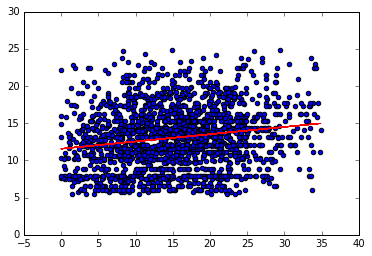

In [21]:
# use .scatter() in matplotlib.pyplot to plot the data and .plot() to add the regression line
# to obtain the regression line, you can use the model predictions from the LinearRegression.predict() method
plt.scatter(X,Y)
plt.plot(X,linreg_univariate.predict(X),color='red')
plt.show()

Other simple things to explore:
* Calculate and plot residuals
* Inspect the residual distribution (probability plot - implemented in scipy.stats.probplot http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.probplot.html)


### Coefficient Estimates

#### t-test
The t-test is used to check the significance of individual regression coefficients. The null hypothesis to test the significance of a particular regression coefficient estimate $\hat{\beta_j}$ is $H_0: \beta_j = 0$, and the alternative $H_1: \beta_j \neq 0$. The test statistic is based on the $t$-distribution and is given by:

$$t = \frac{\beta_j - 0}{SE(\beta_j)},$$

where $SE(\beta_j)$ is the standard error of the $\beta_j$ estimate. The t-statistic basically measures the number of standard deviations that $\beta_j$ is away from 0. If there is no relationship between $X_j$ and $Y$, the t-statistic will have a t-distribution with $N-p-1$ degrees of freedom. In most cases we test whether $\beta_0 = 0$ (these t-statistics are used to test the significance of the corresponding regressor) - however, when the t-statistic is needed to test the hypothesis of the form $H_0: \beta = \beta_0$, then a non-zero $\beta_0$ may be used. The probability of observing any value equal or greater than $|t|$ is the p-value.

The scikit-learn module does not calculate this information, but there are other ways to retrieve it:
* write a piece of code to calculate it when necessary
* extend the LinearRegression class to do this
* use another package, like scipy or statsmodels

Let us use the statmodels implementation of the ordinary least squares to perform the regression and inspect the significance of the coefficient estimates. The documentation can be found here:
http://statsmodels.sourceforge.net/devel/generated/statsmodels.regression.linear_model.OLS.html

In [22]:
import statsmodels.api as sm

#use the statsmodels class OLS and the .fit() method
#statsmodels does not automatically include an intercept term in the linear regression model
#use sm.add_constant() to append a constant term

linreg_univariate_sm = sm.OLS(Y,sm.add_constant(X)).fit()
linreg_univariate_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Interest.Rate   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     59.78
Date:                Thu, 29 Sep 2016   Prob (F-statistic):           1.72e-14
Time:                        00:14:35   Log-Likelihood:                -5294.2
No. Observations:                1873   AIC:                         1.059e+04
Df Residuals:                    1871   BIC:                         1.060e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
const                   11.5667      0.216     53.485      0.000        11.143    11.991
Debt.To.Income.Ratio     0.0977      0.013      7.732      0.000         0.073     0.122
==============================================================================
Omnibus:                       42.628   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.824
Skew:                           0.281   Prob(JB):                     1.01e-08
Kurtosis:                       2.604   Cond. No.                         39.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Model accuracy
We can measure the model accuracy by using several different methods:

#### RSE
The residual standard error (RSE) is an estimate of the standard deviation, and is given by:

$$RSE = \sqrt{\frac{1}{N-p-1}RSS}$$

We can calculate the percentage error of the model as the quotient of the RSE by the output mean value: $\frac{RSE}{\hat{Y}}$.

Note that due to the fact that $RSE$ accounts for $p$, models with more variables can have higher RSE if the decrease in RSS is small relative to the increase in $p$.

#### $R^2$ 
The $R^2$ measure, as opposed to the RSE, provides a measure of the proportion of variance explained by the model. It always takes on a value between 0 and 1 and is given by:

$$R^2 = 1 - \frac{RSS}{TSS},$$

where $TSS = \sum_{i = 1}^{N}(y_i - \bar{y})^2$ is the total sum of squares. 



Let us inspect the accuracy of our univariate regression model, use the .score() method to calculate the $R^2$ value, for both training and test data.

In [23]:
#use the .predict() method to calculate residuals
residuals = Y - linreg_univariate.predict(X)
#calculate the RSS, use np.sum()
RSS = np.sum(residuals**2)
print RSS

#calculate the RSE, using np.sqrt() and len(X) (for the number of observations)
RSE = np.sqrt(RSS/(len(X)-2))
print RSE

#using RSE and the output mean (using np.mean), calculate the percentage error
percentage_error = RSE/np.mean(Y)
print percentage_error

#using the LinearRegression.score() method, calculate the R^2 score for training and test sets
print linreg_univariate.score(X,Y)
print linreg_univariate.score(test[input_variable],test[output_variable])

31274.572669
4.08845101202
0.312793460607
0.0309622504094
0.025881375609


### Considerations:

* How do you comment the fact that this model has such a good p-value for the coefficient estimate t-test, but a very low $R^2$ score?

* Can the $R^2$ score for test set be better than the one for the training set?

* Can the $R^2$ score be negative?


Let us now fit a **multivariate linear regression** model using multiple input variables. Estimate the model accuracy and compare it to the univariate case. Is this model better? 


A very important tool in assessing multivariate regression models is the F-test.


### F-test
The F-test is used to check the significance of multiple regression coefficients. The null hypothsis reads: $H_0: \beta_1,\beta_1,...\beta_p = 0$ and the alternative is $H_1:$ at least one $\beta_j$ is non-zero. The test statistic is given by:

$$F = \frac{(TSS-RSS)/p}{RSS/(N-p-1)}.$$
 
The F-test is also included in the OLS class within the statsmodels package.

In [24]:
# just a reminder on our input_variables
input_variables = ['Amount.Requested',
                     'Loan.Length',
                     'Debt.To.Income.Ratio',
                     'Monthly.Income',
                     'Open.CREDIT.Lines',
                     'Revolving.CREDIT.Balance',
                     'Inquiries.in.the.Last.6.Months',
                     'FICO',
                     'MORTGAGE',
                     'OTHER',
                     'OWN']

#use the LinearRegression class to fit a multivariate linear regression model
X = train[input_variables]
Y = train[output_variable]
linreg_multivariate = linear_model.LinearRegression().fit(X,Y)

# calculate the R^2 score for both the training and test sets
print linreg_multivariate.score(X,Y)
print linreg_multivariate.score(test[input_variables],test[output_variable])

0.755103651694
0.767634713712


Including additional predictions seems to have improved the model - let us check the F-statistic:

In [25]:
# use the statsmodels OLS class to fit the multivariate linear regression model and calculate the F-statistic
# don't forget to add a constant term to the data
linreg_multivariate_sm = sm.OLS(Y,sm.add_constant(X)).fit()
linreg_multivariate_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Interest.Rate   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     521.6
Date:                Thu, 29 Sep 2016   Prob (F-statistic):               0.00
Time:                        00:28:01   Log-Likelihood:                -4006.0
No. Observations:                1873   AIC:                             8036.
Df Residuals:                    1861   BIC:                             8103.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------
const                             68.6802      1.078     63.730      0.000        66.567    70.794
Amount.Requested                   0.0002   7.63e-06     19.767      0.000         0.000     0.000
Loan.Length                        0.1370      0.005     25.853      0.000         0.127     0.147
Debt.To.Income.Ratio              -0.0011      0.007     -0.148      0.883        -0.016     0.013
Monthly.Income                 -1.738e-05   1.47e-05     -1.181      0.238     -4.62e-05  1.15e-05
Open.CREDIT.Lines                 -0.0327      0.012     -2.730      0.006        -0.056    -0.009
Revolving.CREDIT.Balance       -4.283e-06   2.93e-06     -1.462      0.144        -1e-05  1.46e-06
Inquiries.in.the.Last.6.Months     0.3283      0.040      8.293      0.000         0.251     0.406
FICO                              -0.0886      0.001    -60.542      0.000        -0.091    -0.086
MORTGAGE                          -0.1995      0.105     -1.906      0.057        -0.405     0.006
OTHER                             -0.0497      1.194     -0.042      0.967        -2.391     2.291
OWN                                0.0526      0.184      0.285      0.775        -0.309     0.414
==============================================================================
Omnibus:                      164.260   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              324.458
Skew:                           0.575   Prob(JB):                     3.51e-71
Kurtosis:                       4.684   Cond. No.                     6.72e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.72e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Obviously the model has improved by including additional input variables. However, we are almost certain that some of these are more useful for prediction than the others. The scikit-learn package includes several procedures for feature selection. Let us use the SelectKBest function to uncover $K$ individually most significant features. The documentation can be found at: http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html

In [31]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

#use the SelectKBest() class to select a couple of most important regression variables and print the selected column names
X_selection = SelectKBest(f_regression,k=10).fit(X,Y)

#use the .get_support() method to access the mask (boolean indices) of the selected features
print X.columns[X_selection.get_support()]

#fit the reduced model and calculate the R^2 score
reduced_linreg_sklearn = linear_model.LinearRegression().fit(X[X.columns[X_selection.get_support()]],Y)
print reduced_linreg_sklearn.score(X[X.columns[X_selection.get_support()]],Y)
print reduced_linreg_sklearn.score(test[X.columns[X_selection.get_support()]],test[output_variable])

Index([u'Amount.Requested', u'Loan.Length', u'Debt.To.Income.Ratio',
       u'Monthly.Income', u'Open.CREDIT.Lines', u'Revolving.CREDIT.Balance',
       u'Inquiries.in.the.Last.6.Months', u'FICO', u'MORTGAGE', u'OTHER'],
      dtype='object')
0.75509293781
0.767520807254


### Exercise:

* Use multivariate linear regression to explore possible interactions between variables of the dataset, such as products or quotients.

* Include basis expansions of the input variables in the regression - maybe some of the relationships are not linear?



## Regularized regression models

The regularized least squares methods are used to either avoid ill-posed least squares problems when the number of variables is greater than the number of observations, or to avoid overfitting and aid the generalization power of the model. All of the regularization techniques used below include minimizing a linear combination of the RSS and the estimated coefficient magnitudes:
* **Ridge regression** uses L2 norm of the coefficient magnitudes
* **Lasso regression** uses L1 norm of the coefficient magnitudes
* **Elasticnet** uses a combination of the L1 and L2 norms

Since all of these methods include coefficient magnitudes in the penalty function, the parameters and consequently the results will be considerably dependent on the magnitudes of the input variables. This is why it is always recommended to adjust the input variable magnitues by standardizing or normalizing the input.


### Ridge regression
By adding the L2 norm of the coefficient magnitudes to the minimization function, ridge regression avoids overfitting while keeping all of the predictor variables included. The penalty function reads:

$$\underset{\beta}{min\,} {{|| \beta X  - y||_2^2} + \alpha {||\beta||_2^2}}.$$

Due to the added term, with increased value of $\alpha$ the coefficient magnitudes will decrease. Basicall, the model will rely less on a small set of large predictors (due to large corresponding coefficients) and will tend to distribute these weights accors all variables - thus reducing the possibility of overfitting due to sampling flaws.

Ridge regression can be estimated using the sklearn.linear_model.Ridge class the .fit() method. The documentation can be found at: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html


### Lasso regression
Instead of the L2 norm of the coefficient magnitudes, lasso regression uses the L1 prior as a regularizer. The objective function to minimize is:

$$\underset{\beta}{min\,} { \frac{1}{2N} ||\beta X - y||_2 ^ 2 + \alpha ||\beta||_1}.$$

Due to the L1 norm, instead of evenly distributing the coefficients among all the predictor variables, Lasso results in sparse estimates of the regression coefficients - the model tends to set most coefficients to zero, and the other will be assigned high magnitues. Due to this, and inheret variable selection is performed. This is especially useful in cases when the number of variables is larger than the number of observations and the ordinary least squares problem is ill-posed.

Lasso regression is given in the sklearn.linear_model.Lasso class and its parameters can be estimated by calling the .fit() method. The documentation can be found at: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html  


### ElasticNet
The ElasticNet regression model is trained with both L1 and L2 as regularizers. This combination allows for learning a sparse model where few of the weights are non-zero like Lasso, while still maintaining the regularization properties of Ridge.

Elastic-net is useful when there are multiple correlated features - Lasso is likely to pick one of these at random, while elastic-net is likely to pick both. The objective function to minimize is in this case:

$$\underset{\beta}{min\,} { \frac{1}{2N} ||\beta X - y||_2 ^ 2 + \alpha \rho ||\beta||_1 +
\frac{\alpha(1-\rho)}{2} ||\beta||_2 ^ 2}.$$

ElasticNet regression is given in the sklearn.linear_model.ElasticNet class and its parameters can be estimated by calling the .fit() method. The documentation can be found at: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html


<br>


Let us import the necessary modules:

In [35]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

Let us emulate a situation where the number of variables is very high compared to the number of observations in the training set. We will include all of the categorical variables previously ignored.

In [32]:
#first include all the previously ignored predictor variables - the dummy variables for State and Loan.Purpose

loansData.loc[:,'State'] = loansData.loc[:,'State'].astype('category')
dummies = pd.get_dummies(loansData['State'])
loansData = pd.concat([loansData, dummies], axis=1)

loansData.loc[:,'Loan.Purpose'] = loansData.loc[:,'Loan.Purpose'].astype('category')
dummies = pd.get_dummies(loansData['Loan.Purpose'])
loansData = pd.concat([loansData, dummies], axis=1)


In [33]:
#let us split the data into training and test sets, in such a way that N < p

train, test = train_test_split(loansData, test_size = 0.98,random_state=1950)
input_variables = train.select_dtypes(include=['float64','int64']).drop('Interest.Rate', axis=1).columns

X = train[input_variables]
Y = train['Interest.Rate']

print train.shape
print test.shape

(49, 79)
(2449, 79)


### Ridge trace:
Use the sklearn.linear_model regularized regressions to explore the relationship between the regularization parameter $\alpha$ and the estimated coefficient values for ridge regression.

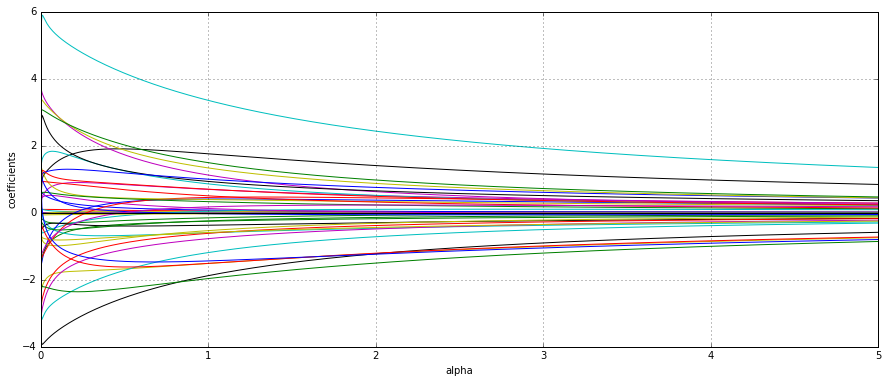

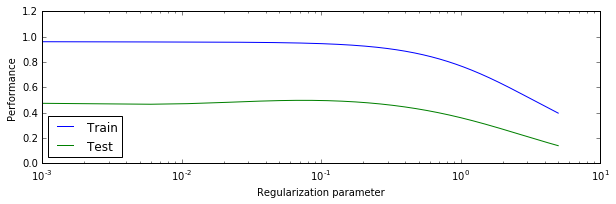

In [36]:
alphas = np.linspace(0.001, 5, num=1000)
ridge_regr = Ridge(alpha = alphas[0],normalize=True)

coefficients = []
train_performance = []
test_performance = []
for a in alphas:
    ridge_regr.set_params(alpha=a)
    ridge_regr.fit(X,Y)
    coefficients.append(ridge_regr.coef_)
    train_performance.append(ridge_regr.score(X, Y))
    test_performance.append(ridge_regr.score(test[input_variables], test['Interest.Rate']))



figure(num=None, figsize=(15, 6), dpi=200)
h = plt.plot(alphas, coefficients)
plt.xlabel('alpha')
plt.ylabel('coefficients')
plt.grid(True)
plt.show()

figure(num=None, figsize=(10, 6), dpi=200)
plt.subplot(2, 1, 1)
plt.semilogx(alphas, train_performance, label='Train')
plt.semilogx(alphas, test_performance, label='Test')
plt.legend(loc='lower left')
plt.ylim([0, 1.2])
plt.xlabel('Regularization parameter')
plt.ylabel('Performance')
plt.show()

Now repeat this procedure and inspect the relationship between the parameter $\alpha$ values and the Lasso regression coefficients. Also explore the train and test set model performance.

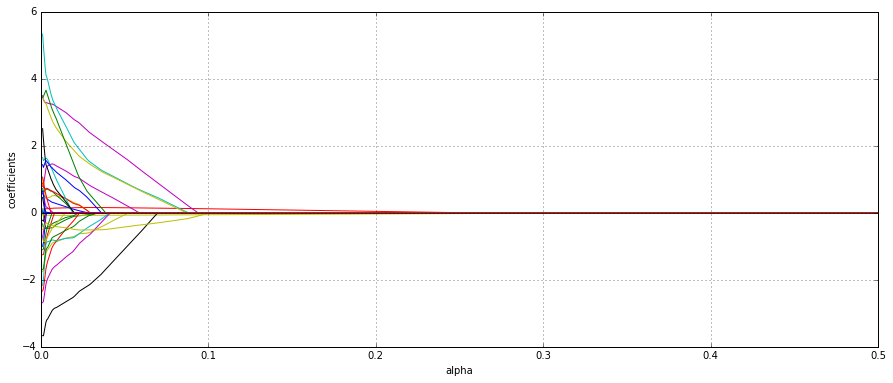

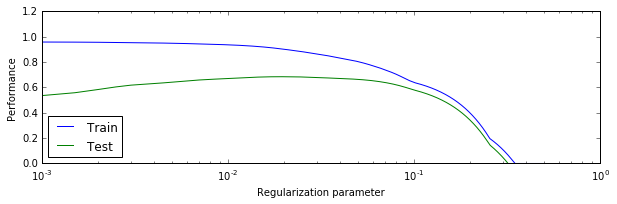

In [39]:
#copy-paste the code in the previous cell and use the Lasso() class to fit a lasso regularized regression model
alphas = np.linspace(0.001, 0.5, num=1000)
ridge_regr = Lasso(alpha = alphas[0],normalize=True)

coefficients = []
train_performance = []
test_performance = []
for a in alphas:
    ridge_regr.set_params(alpha=a)
    ridge_regr.fit(X,Y)
    coefficients.append(ridge_regr.coef_)
    train_performance.append(ridge_regr.score(X, Y))
    test_performance.append(ridge_regr.score(test[input_variables], test['Interest.Rate']))



figure(num=None, figsize=(15, 6), dpi=200)
h = plt.plot(alphas, coefficients)
plt.xlabel('alpha')
plt.ylabel('coefficients')
plt.grid(True)
plt.show()

figure(num=None, figsize=(10, 6), dpi=200)
plt.subplot(2, 1, 1)
plt.semilogx(alphas, train_performance, label='Train')
plt.semilogx(alphas, test_performance, label='Test')
plt.legend(loc='lower left')
plt.ylim([0, 1.2])
plt.xlabel('Regularization parameter')
plt.ylabel('Performance')
plt.show()

Do the same for the values of the $\alpha$ and $\rho$ parameters and the ElasticNet regression:

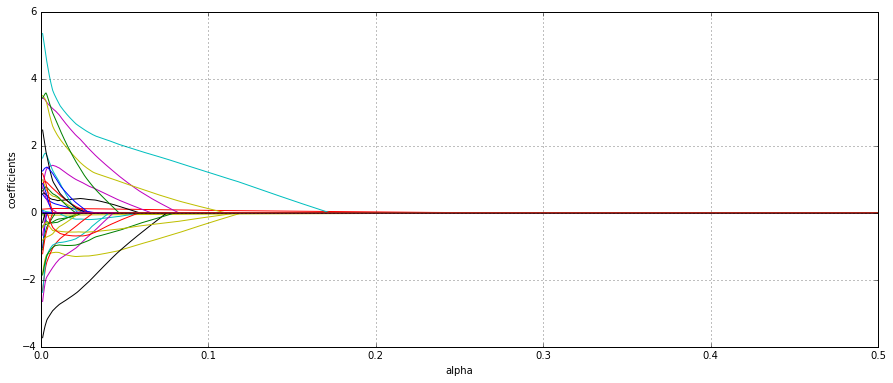

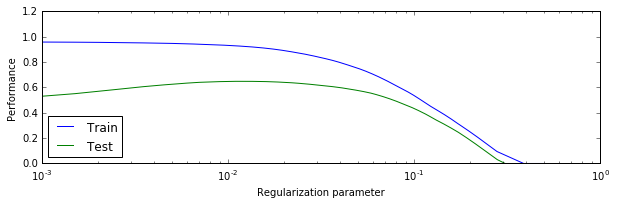

In [40]:
#copy-paste the code in the previous cell and use the ElasticNet() class to fit a lasso regularized regression model
#set the value of the l1_ratio to 0.9
alphas = np.linspace(0.001, 0.5, num=1000)
ridge_regr = ElasticNet(l1_ratio = 0.9,alpha = alphas[0],normalize=True)

coefficients = []
train_performance = []
test_performance = []
for a in alphas:
    ridge_regr.set_params(alpha=a)
    ridge_regr.fit(X,Y)
    coefficients.append(ridge_regr.coef_)
    train_performance.append(ridge_regr.score(X, Y))
    test_performance.append(ridge_regr.score(test[input_variables], test['Interest.Rate']))



figure(num=None, figsize=(15, 6), dpi=200)
h = plt.plot(alphas, coefficients)
plt.xlabel('alpha')
plt.ylabel('coefficients')
plt.grid(True)
plt.show()

figure(num=None, figsize=(10, 6), dpi=200)
plt.subplot(2, 1, 1)
plt.semilogx(alphas, train_performance, label='Train')
plt.semilogx(alphas, test_performance, label='Test')
plt.legend(loc='lower left')
plt.ylim([0, 1.2])
plt.xlabel('Regularization parameter')
plt.ylabel('Performance')
plt.show()

### Choosing $\alpha$

The parameter $\alpha$ is usually chosen using K-fold cross validation: we pick the $\alpha$ with the least overall cross validation error (CVE). This is implemented in scikit-learn within the RidgeCV, LassoCV and ElasticNetCV classes.

http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV

http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV

http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV

In [42]:
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV

### Exercise:

* **Fit a multivariate linear regression model (non-regularized) and inspect the model accuracy**
    What is the $R^2$ score on the train data? What is the score on the test data? How do you comment this?


* **Fit an L2-regularized regression model (Ridge regression) to the dataset and inspect the model accuracy**
    Find a favorable value of the parameter $\alpha$ (normalize the input variables). What are the $R^2$ scores for the train and test data?
    
    
* **Fit an L1-regularized regression model (Lasso regression) to the dataset and inspect the model accuracy**
    Which variables have non-zero coefficients? Do they match the selected coefficients in the earlier example?
    
    
* **Fit an ElasticNet regression model to the dataset and inspect the model accuracy**
    What is the accuracy of the model on the train and test datasets?


In [50]:
linreg = linear_model.LinearRegression().fit(X,Y)

print linreg.score(X,Y)
print linreg.score(test[input_variables],test['Interest.Rate'])

0.960748789406
0.459138077393


In [51]:
alphas = np.linspace(0.01,5,100)
ridgecv_model = RidgeCV(alphas = alphas,normalize=True)
ridgecv_model.fit(X,Y)

print ridgecv_model.score(X,Y)
print ridgecv_model.score(test[input_variables],test['Interest.Rate'])

0.943111467281
0.495363737113


In [52]:
alphas = np.linspace(0.01,5,1000)
lassocv_model = LassoCV(alphas = alphas,normalize=True)
lassocv_model.fit(X,Y)

print lassocv_model.score(X,Y)
print lassocv_model.score(test[input_variables],test['Interest.Rate'])

0.787061838661
0.658134685505


In [53]:
alphas = np.linspace(0.001,1,1000)
l1_ratios = np.linspace(0.1,1,10)
elasticnetcv_model = ElasticNetCV(l1_ratio = l1_ratios,alphas = alphas,normalize=True)
elasticnetcv_model.fit(X,Y)

print elasticnetcv_model.score(X,Y)
print elasticnetcv_model.score(test[input_variables],test['Interest.Rate'])

0.786915522123
0.65808747474


### Variable selection using Lasso

Let us turn back to the Lasso L1 regularized regression model. Due to the inherent sparsity of the coefficient estimates, this is an especially convenient method for variable selection. The idea is simple: find an optimal value of $\alpha$ using cross-validation, and then explore the estimated regression coefficients - those different than 0 correspond to valuable input variables.


Let us detect which coefficients our Lasso model chose as significant.

In [54]:
#use the fitted lasso model and the .coef_ attribute to access the coefficients
#print out those column namse whose corresponding coefficients are != 0

print X.columns[lassocv_model.coef_!= 0]
zip(X.columns[lassocv_model.coef_!= 0],lassocv_model.coef_[lassocv_model.coef_!= 0])

Index([u'Amount.Funded.By.Investors', u'Loan.Length', u'FICO', u'CO', u'IN',
       u'MD', u'NC', u'debt_consolidation', u'other'],
      dtype='object')


[('Amount.Funded.By.Investors', 3.5989462265457206e-05),
 ('Loan.Length', 0.14987139315818446),
 ('FICO', -0.066956276287108416),
 ('CO', 0.11178335527400535),
 ('IN', -0.81292203756724812),
 ('MD', 1.4594454311593339),
 ('NC', 0.78642964466933563),
 ('debt_consolidation', -0.38737004039821593),
 ('other', 0.77247650264504875)]

How do these coefficients compare to our identified significant coefficients above (when using SelectKBest)? Note that these are completely different models, due to added variables and a significantly reduced training set - nevertheless, some variables seem to be important in both cases.




# Logistic regression

Rather than predicting the interest rate given a set of input parameter values, sometimes it is useful to consider binary outcomes: "Is it possible to get a loan with an interest rate of 12%, given one's parameter values?"

If we characterize all loans with the interest rate above the threshold of 12% as unaffordable and all others as affordable - the question we face read: "What is the probability of getting an affordable loan, given one's parameters?"

### Classification via logistic regression
Logistic regression is a linear model for classification, also known in the literature as logit regression, maximum-entropy classification (MaxEnt) or the log-linear classifier. In this model, the probabilities describing the possible outcomes of a single trial are modeled using a logistic function.

The implementation of logistic regression in scikit-learn includes optional L2 or L1 regularization. As in previous examples, regularization helps avoid overfitting and deals with a large number of variables with insufficient observations. As an optimization problem, binary class L2 penalized logistic regression minimizes the following cost function:
$$\underset{w, c}{min\,} \frac{1}{2}w^T w + C \sum_{i=1}^n \log(\exp(- y_i (X_i^T w + c)) + 1) .$$
Similarly, L1 regularized logistic regression solves the following optimization problem
$$\underset{w, c}{min\,} \|w\|_1 + C \sum_{i=1}^n \log(\exp(- y_i (X_i^T w + c)) + 1) .$$

The parameter $C$ can be set to very high values to simply annul the regularization. More can be found in the documentation: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

A very useful notebook covering the logistic regression model in statsmodels is given here: http://blog.yhat.com/posts/logistic-regression-and-python.html

Another notebook, using scikit-learn is available here: http://www.dataschool.io/logistic-regression-in-python-using-scikit-learn/

Literature
-----------

<a name="scikit-linear">[1]</a> scikit-learn documentation - 1.1. Generalized Linear Models, [link](http://scikit-learn.org/stable/modules/linear_model.html)

<a name="statsmodels">[2]</a> statsmodels documentation, [link](https://pypi.python.org/pypi/statsmodels)

<a name="islr">[3]</a> James, G., Witten, D., Hastie, T., and Tibshirani, R. (2014), An Introduction to Statistical Learning: With Applications in R. Springer Publishing Company, Inc., [link](http://www-bcf.usc.edu/~gareth/ISL/)

<a name="esl">[4]</a> Hastie, T.; Tibshirani, R. & Friedman, J. (2001), The Elements of Statistical Learning, Springer New York Inc., New York, NY, USA. [link](http://statweb.stanford.edu/~tibs/ElemStatLearn/)

<a name="scikit-linreg">[5]</a> ISLR - Python, [link](https://github.com/JWarmenhoven/ISLR-python)